<a href="https://colab.research.google.com/github/grrr71/playround/blob/main/users_pm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import requests
import os


# Helper Functions

In [2]:
def analyze_user_activity(user_activity_data):
    """
    Analyzes user activity data and returns descriptive statistics.

    :param user_activity_data: List of JSON responses from the activity endpoint.
    :return: Dictionary containing key statistics.
    """
    # Convert to DataFrame
    df = pd.DataFrame(user_activity_data)

    if df.empty:
        return None

    # Convert timestamp to human-readable format
    first_trade_time = datetime.utcfromtimestamp(df["timestamp"].min()).strftime('%Y-%m-%d %H:%M:%S UTC')
    last_trade_time = datetime.utcfromtimestamp(df["timestamp"].max()).strftime('%Y-%m-%d %H:%M:%S UTC')

    # Compute average time between trades
    df = df.sort_values(by="timestamp")
    df["time_diff"] = df["timestamp"].diff()
    avg_time_between_trades = df["time_diff"].mean()

    # Convert average time between trades to human-readable format
    avg_time_between_trades_str = str(timedelta(seconds=avg_time_between_trades)) if not pd.isna(avg_time_between_trades) else "N/A"

    # Compute descriptive statistics
    stats = {
        "Total Trades": len(df),
        "Total Buy Trades": len(df[df["side"] == "BUY"]),
        "Total Sell Trades": len(df[df["side"] == "SELL"]),
        "Total Size Traded": df["size"].sum(),
        "Average Trade Size": df["size"].mean(),
        "Largest Trade Size": df["size"].max(),
        "Total USDC Spent": df["usdcSize"].sum(),
        "Average Price": df["price"].mean(),
        "Markets Traded": df["title"].nunique(),
        "First Trade Time": first_trade_time,
        "Last Trade Time": last_trade_time,
        "Average Time Between Trades": avg_time_between_trades_str,
    }

    return stats


In [3]:
def generate_user_statistics(user_ids, base_url):
    """
    Fetches activity data for multiple users and compiles statistics into a table.

    :param user_ids: List of user IDs to analyze.
    :param base_url: The base URL of the API.
    :return: DataFrame containing statistics for all users.
    """
    user_stats = []
    for user in user_ids:
        url = f"{base_url}/activity?user={user}&limit=500"
        response = requests.get(url, headers={"Accept": "application/json"})
        if response.status_code == 200:
            data = response.json()
            stats = analyze_user_activity(data)
            if stats:
                stats["User ID"] = user
                user_stats.append(stats)

    return pd.DataFrame(user_stats)


In [4]:
def fetch_users_from_trades(base_url, limit=500):
    """
    Fetches unique user IDs from the trades API.

    :param base_url: The base URL of the API.
    :param limit: The number of trades to fetch.
    :return: Set of unique user IDs.
    """
    url = f"{base_url}/trades?limit={limit}"
    response = requests.get(url, headers={"Accept": "application/json"})

    if response.status_code == 200:
        data = response.json()
        return {trade["proxyWallet"] for trade in data if "proxyWallet" in trade}

    print(f"Error fetching users from trades: {response.text}")
    return set()

In [5]:
def read_users_from_file(file_path):
    """
    Reads user data from a CSV file and returns it as a list.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        list: A list of user IDs (or other data) from the file.
    """
    try:
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            return []

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert the 'User ID' column to a list
        users = df["User ID"].tolist()

        return users
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return []

# Run

In [11]:
# Example usage
example_user_ids = ["0xf373fe97c47d5cbe936bf4ae433e2abb10c3002d", "0xa1234b56789cdef0123456789abcdef123456789"]
pm_base_url = "https://data-api.polymarket.com/"  # Replace with actual API base URL
#initial_user_ids = fetch_users_from_trades(pm_base_url)



In [30]:

print(f"Local Users before update: {len(users)}")
new_users = fetch_users_from_trades(pm_base_url)
users = users.union(new_users)
print(f"Users after update {len(users)}")

Local Users before update: 632
Users after update 974


In [ ]:
df = generate_user_statistics(list(users), pm_base_url)

In [16]:
df


,Total Trades,Total Buy Trades,Total Sell Trades,Total Size Traded,Average Trade Size,Largest Trade Size,Total USDC Spent,Average Price,Markets Traded,First Trade Time,Last Trade Time,Average Time Between Trades,User ID
0,23,10,1,1130.574479,49.155412,1000.000000,98.931452,0.295643,10,2024-12-08 13:52:56 UTC,2025-03-17 01:11:07 UTC,"4 days, 11:25:22.318182",0x7ea39e9e6c726f9589a60d725c67f68577f29340
1,334,167,167,17769.920000,53.203353,100.000000,17708.692160,0.996563,117,2024-10-24 01:41:42 UTC,2025-03-17 01:18:05 UTC,10:22:37.906907,0xe467006c9a68785bf79da8aa05be0daf5aefea62
2,61,33,0,703.485388,11.532547,111.111111,176.232952,0.124918,33,2024-12-24 16:31:45 UTC,2025-03-17 01:20:23 UTC,"1 day, 8:56:48.633333",0x09c39379ed309c434e767c0b6fc08600882b1650
3,24,11,1,1148.167284,47.840304,1000.000000,111.623570,0.289452,10,2024-12-08 14:54:38 UTC,2025-03-17 01:12:27 UTC,"4 days, 6:42:30.826087",0xe60427f1672f334b3c63258342155f06a1ed7c91
4,42,33,1,258.098075,6.145192,20.000000,189.076701,0.530929,13,2025-03-15 00:00:20 UTC,2025-03-17 01:10:03 UTC,1:11:56.658537,0xd02a88f113c06703774d383c6da8ce4dfb85c712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,19,14,0,1138.470290,59.919489,1100.000000,39.473387,0.681579,11,2025-01-07 01:57:08 UTC,2025-03-17 01:22:55 UTC,"3 days, 19:58:05.944444",0x397b7c3bee176a3c4c1062a106b68f3e2a16f461
347,500,254,0,63368.887698,126.737775,833.333332,41882.584869,0.290385,255,2025-03-08 06:59:41 UTC,2025-03-17 01:15:53 UTC,0:25:16.977956,0x8b7e69788fa1145068d0d418c822c6f81d996a9f
348,4,2,2,114.060666,28.515166,28.740000,113.604424,0.996000,1,2025-03-17 01:03:29 UTC,2025-03-17 01:14:03 UTC,0:03:31.333333,0x25945924dddcd907c1e29bf8db0e9de0674a1d4b
349,500,486,3,5500.091939,11.000184,461.290000,3646.911760,0.522486,10,2025-03-14 14:38:07 UTC,2025-03-17 01:20:11 UTC,0:07:03.494990,0x78bf9e470db01d90b5e7826149ec4a5bcad37300


In [17]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1M7En6ny7mDVCkktss5FqTwxl9BvIRUZ5Om18fw1XbHk#gid=0


# Plots

In [26]:
df

,Total Trades,Total Buy Trades,Total Sell Trades,Total Size Traded,Average Trade Size,Largest Trade Size,Total USDC Spent,Average Price,Markets Traded,First Trade Time,Last Trade Time,Average Time Between Trades,User ID
0,23,10,1,1130.574479,49.155412,1000.000000,98.931452,0.295643,10,2024-12-08 13:52:56 UTC,2025-03-17 01:11:07 UTC,"4 days, 11:25:22.318182",0x7ea39e9e6c726f9589a60d725c67f68577f29340
1,334,167,167,17769.920000,53.203353,100.000000,17708.692160,0.996563,117,2024-10-24 01:41:42 UTC,2025-03-17 01:18:05 UTC,10:22:37.906907,0xe467006c9a68785bf79da8aa05be0daf5aefea62
2,61,33,0,703.485388,11.532547,111.111111,176.232952,0.124918,33,2024-12-24 16:31:45 UTC,2025-03-17 01:20:23 UTC,"1 day, 8:56:48.633333",0x09c39379ed309c434e767c0b6fc08600882b1650
3,24,11,1,1148.167284,47.840304,1000.000000,111.623570,0.289452,10,2024-12-08 14:54:38 UTC,2025-03-17 01:12:27 UTC,"4 days, 6:42:30.826087",0xe60427f1672f334b3c63258342155f06a1ed7c91
4,42,33,1,258.098075,6.145192,20.000000,189.076701,0.530929,13,2025-03-15 00:00:20 UTC,2025-03-17 01:10:03 UTC,1:11:56.658537,0xd02a88f113c06703774d383c6da8ce4dfb85c712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,19,14,0,1138.470290,59.919489,1100.000000,39.473387,0.681579,11,2025-01-07 01:57:08 UTC,2025-03-17 01:22:55 UTC,"3 days, 19:58:05.944444",0x397b7c3bee176a3c4c1062a106b68f3e2a16f461
347,500,254,0,63368.887698,126.737775,833.333332,41882.584869,0.290385,255,2025-03-08 06:59:41 UTC,2025-03-17 01:15:53 UTC,0:25:16.977956,0x8b7e69788fa1145068d0d418c822c6f81d996a9f
348,4,2,2,114.060666,28.515166,28.740000,113.604424,0.996000,1,2025-03-17 01:03:29 UTC,2025-03-17 01:14:03 UTC,0:03:31.333333,0x25945924dddcd907c1e29bf8db0e9de0674a1d4b
349,500,486,3,5500.091939,11.000184,461.290000,3646.911760,0.522486,10,2025-03-14 14:38:07 UTC,2025-03-17 01:20:11 UTC,0:07:03.494990,0x78bf9e470db01d90b5e7826149ec4a5bcad37300


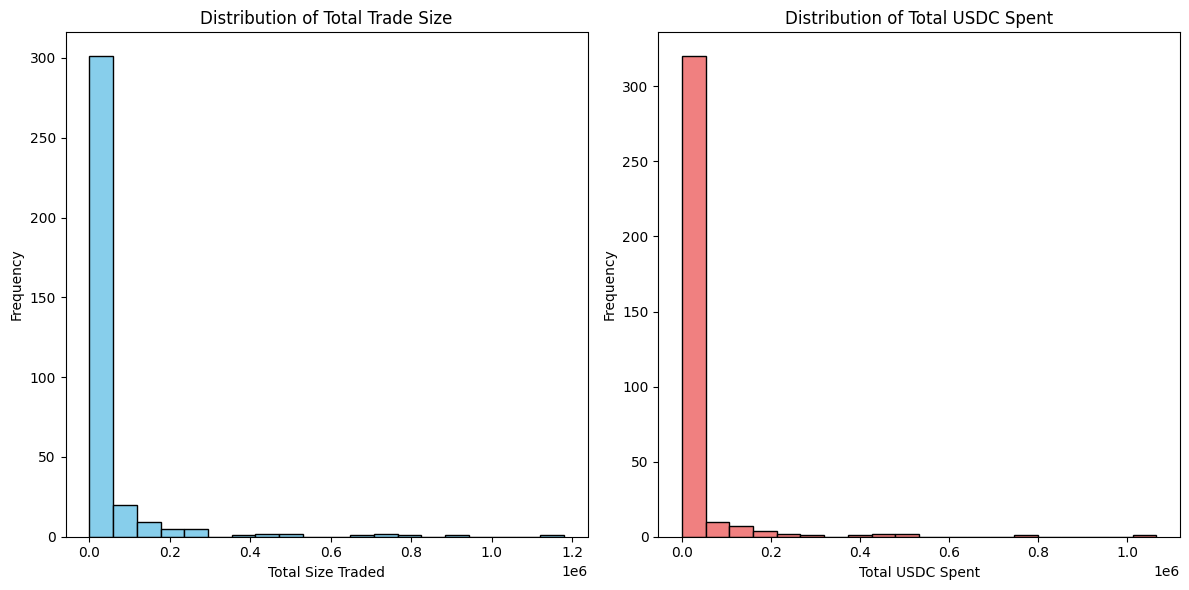

In [28]:
# prompt: i dont like those, focus more on histogram plots and the distribution of total trade size and total usds spent

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame from the previous code
plt.figure(figsize=(12, 6))

# Histogram of Total Trade Size
plt.subplot(1, 2, 1)
plt.hist(df['Total Size Traded'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Trade Size')
plt.xlabel('Total Size Traded')
plt.ylabel('Frequency')

# Histogram of Total USDC Spent
plt.subplot(1, 2, 2)
plt.hist(df['Total USDC Spent'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Total USDC Spent')
plt.xlabel('Total USDC Spent')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming your DataFrame is named 'df'
columns_to_plot = [
    'Total Trades', 'Total Buy Trades', 'Total Sell Trades',
    'Total Size Traded', 'Average Trade Size', 'Largest Trade Size',
    'Total USDC Spent', 'Average Price', 'Markets Traded'
]

# Create a 3x3 subplot grid
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=columns_to_plot,
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

# Add histograms for each column
for i, col in enumerate(columns_to_plot, 1):
    row = (i - 1) // 3 + 1  # Row index (1-based)
    col_num = (i - 1) % 3 + 1  # Column index (1-based)
    fig.add_trace(
        go.Histogram(x=df[col], name=col, showlegend=False),
        row=row,
        col=col_num
    )

# Update layout
fig.update_layout(
    title_text="Histograms of Trading Metrics",
    height=900,
    width=1200,
    showlegend=False
)

# Show the figure
fig.show()

In [19]:
import plotly.express as px

fig = px.histogram(
    df,
    x='Total Trades',
    title='Total Trades Distribution (Auto Bins)',
    labels={'Total Trades': 'Number of Trades'}
)
fig.show()

In [20]:
df[df['Total USDC Spent'] < 4000]

,Total Trades,Total Buy Trades,Total Sell Trades,Total Size Traded,Average Trade Size,Largest Trade Size,Total USDC Spent,Average Price,Markets Traded,First Trade Time,Last Trade Time,Average Time Between Trades,User ID
0,23,10,1,1130.574479,49.155412,1000.000000,98.931452,0.295643,10,2024-12-08 13:52:56 UTC,2025-03-17 01:11:07 UTC,"4 days, 11:25:22.318182",0x7ea39e9e6c726f9589a60d725c67f68577f29340
2,61,33,0,703.485388,11.532547,111.111111,176.232952,0.124918,33,2024-12-24 16:31:45 UTC,2025-03-17 01:20:23 UTC,"1 day, 8:56:48.633333",0x09c39379ed309c434e767c0b6fc08600882b1650
3,24,11,1,1148.167284,47.840304,1000.000000,111.623570,0.289452,10,2024-12-08 14:54:38 UTC,2025-03-17 01:12:27 UTC,"4 days, 6:42:30.826087",0xe60427f1672f334b3c63258342155f06a1ed7c91
4,42,33,1,258.098075,6.145192,20.000000,189.076701,0.530929,13,2025-03-15 00:00:20 UTC,2025-03-17 01:10:03 UTC,1:11:56.658537,0xd02a88f113c06703774d383c6da8ce4dfb85c712
6,59,30,21,10952.795410,185.640600,1530.000000,3883.927825,0.232508,27,2024-12-18 10:43:59 UTC,2025-03-17 01:10:47 UTC,"1 day, 12:39:46.344828",0x345464c63c5b1d282c403711635867fe3ab4d280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,3,2,1,41.000000,13.666667,17.000000,25.722000,0.695333,2,2025-03-16 13:58:00 UTC,2025-03-17 01:16:47 UTC,5:39:23.500000,0x85a7765c0c7155b0c3b4806a27a7ccf56bd02cf9
346,19,14,0,1138.470290,59.919489,1100.000000,39.473387,0.681579,11,2025-01-07 01:57:08 UTC,2025-03-17 01:22:55 UTC,"3 days, 19:58:05.944444",0x397b7c3bee176a3c4c1062a106b68f3e2a16f461
348,4,2,2,114.060666,28.515166,28.740000,113.604424,0.996000,1,2025-03-17 01:03:29 UTC,2025-03-17 01:14:03 UTC,0:03:31.333333,0x25945924dddcd907c1e29bf8db0e9de0674a1d4b
349,500,486,3,5500.091939,11.000184,461.290000,3646.911760,0.522486,10,2025-03-14 14:38:07 UTC,2025-03-17 01:20:11 UTC,0:07:03.494990,0x78bf9e470db01d90b5e7826149ec4a5bcad37300


In [22]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df[df['Total USDC Spent'] < 3000]['Total USDC Spent'],
    nbinsx=100,  # Explicitly set number of bins
    name='Total Trades'
))
fig.add_trace(go.Histogram(
    x=df[df['Total Size Traded'] < 3000]['Total USDC Spent'],
    nbinsx=100,  # Explicitly set number of bins
))
fig.update_layout(
    title='Total USDC Spent Distribution (30 Bins)',
    xaxis_title='Total USDC Spent',
    yaxis_title='Frequency'
)
fig.show()

In [23]:
fig = px.histogram(df, x="Total Size Traded",
                   marginal="rug", # or violin, rug
                   hover_data=df.columns)
fig.show()

In [24]:
fig = px.histogram(df, x="Total USDC Spent", y="Total Size Traded",
                   marginal="rug", # or violin, rug
                   hover_data=df.columns)
fig.show()

In [25]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df['Average Trade Size'],
    nbinsx=100,  # Explicitly set number of bins
    name='Total Trades'
))
fig.update_layout(
    title='Average Trade Size Distribution (30 Bins)',
    xaxis_title='Average Trade Size',
    yaxis_title='Frequency'
)
fig.show()

,Total Trades,Total Buy Trades,Total Sell Trades,Total Size Traded,Average Trade Size,Largest Trade Size,Total USDC Spent,Average Price,Markets Traded,First Trade Time,Last Trade Time,Average Time Between Trades,User ID
0,42,22,4,68388.173694,1628.289850,33955.250000,539.581084,0.448238,18,2025-02-14 02:52:22 UTC,2025-03-16 22:31:11 UTC,18:02:24.609756,0xd0a03fb98504a31160cd8849d5c0716bc476e32a
1,84,41,31,11942.459718,142.172140,5500.000000,10970.009807,0.127988,40,2024-11-26 06:01:21 UTC,2025-03-16 21:55:33 UTC,"1 day, 7:59:55.807229",0x50d0c63a2a3db69d87a771232b50a2628c61f845
2,500,403,69,4936.851801,9.873704,259.000000,2881.627667,0.585908,83,2025-03-09 04:51:04 UTC,2025-03-16 22:49:35 UTC,0:22:21.705411,0x9edc2ce62c68b25eca4d0799d8212f9f67d1b088
3,4,2,2,125.960444,31.490111,32.415185,122.433552,0.972000,1,2025-03-16 22:34:05 UTC,2025-03-16 22:41:19 UTC,0:02:24.666667,0xbb550d1ce83a0bb0ae7f585a7960816a6b4adc31
4,22,9,13,346.000000,15.727273,67.000000,53.395000,0.191045,4,2025-03-14 14:52:11 UTC,2025-03-16 21:59:15 UTC,2:37:28.761905,0x0550e615e3d4f9d312478085ee163cfb7262de94
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,500,259,190,128695.020007,257.390040,10000.000000,73497.126472,0.483949,72,2025-03-08 16:24:50 UTC,2025-03-16 22:47:01 UTC,0:23:51.124248,0x0f37cb80dee49d55b5f6d9e595d52591d6371410
1145,133,97,29,77546.900405,583.059402,5807.000000,58113.147114,0.627348,16,2024-10-24 22:14:51 UTC,2025-03-16 22:46:55 UTC,"1 day, 2:00:14.575758",0x16d56c02164ae5d8061958dda65ec852a9825e0c
1146,15,11,4,1338.368120,89.224541,1000.000000,912.140148,0.928124,11,2025-03-03 16:20:26 UTC,2025-03-16 22:51:39 UTC,22:45:05.214286,0x74618a339c414ed4854861b26308c19cc334e282
1147,28,14,9,15493.558948,553.341391,4660.000000,500.228490,0.639321,13,2024-12-29 23:28:13 UTC,2025-03-16 22:41:19 UTC,"2 days, 20:24:55.777778",0x87a5f961f0b13c507e766c7040fea55d0599c154
